In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import math
%matplotlib inline

# Read images

In [2]:
# Load the four input images
image1 = cv2.imread('./panorama/scene1.jpg', cv2.IMREAD_COLOR)
image2 = cv2.imread('./panorama/scene2.jpg', cv2.IMREAD_COLOR)
image3 = cv2.imread('./panorama/scene3.jpg', cv2.IMREAD_COLOR)
image4 = cv2.imread('./panorama/scene4.jpg', cv2.IMREAD_COLOR)

Text(0.5, 1.0, 'Scene_4')

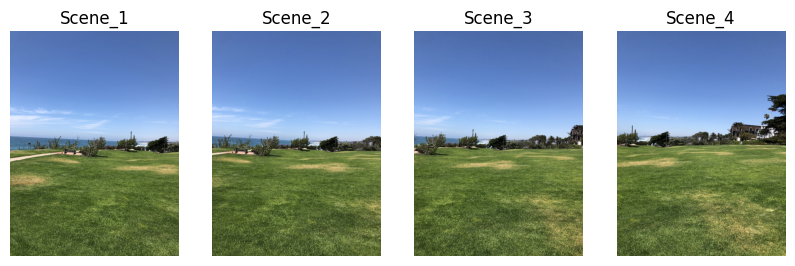

In [3]:
plt.figure(figsize=[10,6]);
plt.subplot(141); plt.axis('off'); plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)); plt.title("Scene_1")
plt.subplot(142); plt.axis('off'); plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)); plt.title("Scene_2")
plt.subplot(143); plt.axis('off'); plt.imshow(cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)); plt.title("Scene_3")
plt.subplot(144); plt.axis('off'); plt.imshow(cv2.cvtColor(image4, cv2.COLOR_BGR2RGB)); plt.title("Scene_4")

# Feature detection and description

In [4]:
im1Gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
im2Gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
im3Gray = cv2.cvtColor(image3, cv2.COLOR_BGR2GRAY)
im4Gray = cv2.cvtColor(image4, cv2.COLOR_BGR2GRAY)

In [5]:
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors for each image
kp1, des1 = sift.detectAndCompute(im1Gray, None)
kp2, des2 = sift.detectAndCompute(im2Gray, None)
kp3, des3 = sift.detectAndCompute(im3Gray, None)
kp4, des4 = sift.detectAndCompute(im4Gray, None)

In [6]:
img1kp = cv2.drawKeypoints(image1, kp1, outImage=np.array([]), color=(0,0,255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2kp = cv2.drawKeypoints(image2, kp2, outImage=np.array([]), color=(0,0,255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img3kp = cv2.drawKeypoints(image3, kp3, outImage=np.array([]), color=(0,0,255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img4kp = cv2.drawKeypoints(image4, kp4, outImage=np.array([]), color=(0,0,255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

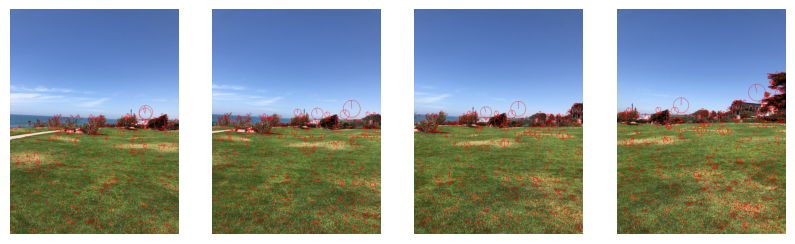

In [7]:
plt.figure(figsize=[10,6]);
plt.subplot(141); plt.axis('off'); plt.imshow(cv2.cvtColor(img1kp, cv2.COLOR_BGR2RGB));
plt.subplot(142); plt.axis('off'); plt.imshow(cv2.cvtColor(img2kp, cv2.COLOR_BGR2RGB));
plt.subplot(143); plt.axis('off'); plt.imshow(cv2.cvtColor(img3kp, cv2.COLOR_BGR2RGB));
plt.subplot(144); plt.axis('off'); plt.imshow(cv2.cvtColor(img4kp, cv2.COLOR_BGR2RGB));

# Feature Matching

In [8]:
# Initialize a brute force matcher
bf = cv2.BFMatcher()

# Match descriptors between adjacent images
matches12 = bf.knnMatch(des1, des2, k=2)
matches23 = bf.knnMatch(des2, des3, k=2)
matches34 = bf.knnMatch(des3, des4, k=2)

# Apply Lowe's ratio test to filter good matches
good_matches12 = []
for m, n in matches12:
    if m.distance < 0.75 * n.distance:
        good_matches12.append([m])

good_matches23 = []
for m, n in matches23:
    if m.distance < 0.75 * n.distance:
        good_matches23.append([m])

good_matches34 = []
for m, n in matches34:
    if m.distance < 0.75 * n.distance:
        good_matches34.append([m])



In [9]:
im12_matched = cv2.drawMatchesKnn(image1,kp1,image2,kp2,good_matches12,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
im23_matched = cv2.drawMatchesKnn(image2,kp2,image3,kp3,good_matches23,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
im34_matched = cv2.drawMatchesKnn(image3,kp3,image4,kp4,good_matches34,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

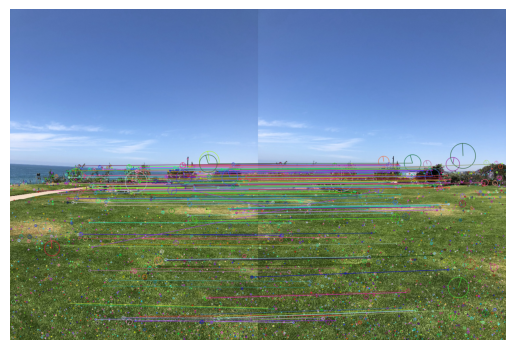

In [10]:
plt.imshow(cv2.cvtColor(im12_matched, cv2.COLOR_BGR2RGB));plt.axis('off');

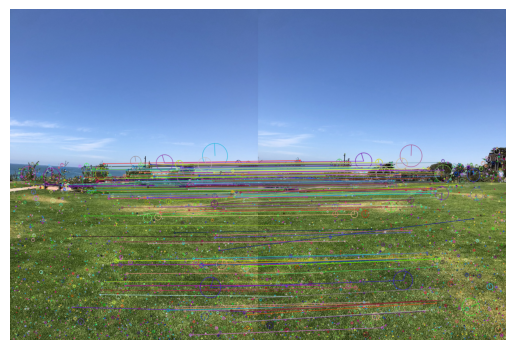

In [11]:
plt.imshow(cv2.cvtColor(im23_matched, cv2.COLOR_BGR2RGB));plt.axis('off');

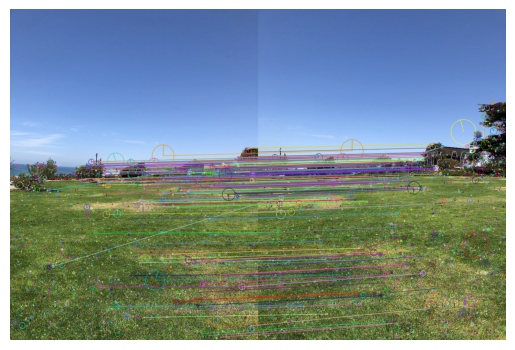

In [12]:
plt.imshow(cv2.cvtColor(im34_matched, cv2.COLOR_BGR2RGB));plt.axis('off');

In [13]:
# Use RANSAC to find the transformation matrices
def ransac_transform(kp1, kp2, matches):
  src_pts = np.zeros((len(matches), 2), dtype=np.float32)
  dst_pts = np.zeros((len(matches), 2), dtype=np.float32)

  for i, match in enumerate(matches):
      dst_pts[i, :] = kp1[match[0].queryIdx].pt
      src_pts[i, :] = kp2[match[0].trainIdx].pt

  M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)
  return M

M12 = ransac_transform(kp1, kp2, good_matches12)
M23 = ransac_transform(kp2, kp3, good_matches23)
M34 = ransac_transform(kp3, kp4, good_matches34)

#Warp and stitching

## Image 4 -> Image 3

### Warp image4 to image3

In [14]:
# Calculate the size of the output image
h, w = image3.shape[:2]
pano_width = w + image4.shape[1]
pano_height = h

In [15]:
print(h,w)
print(pano_width, pano_height)

1008 756
1512 1008


In [16]:
pano = cv2.warpPerspective(image4, M34, (pano_width, pano_height))

(np.float64(-0.5), np.float64(1511.5), np.float64(1007.5), np.float64(-0.5))

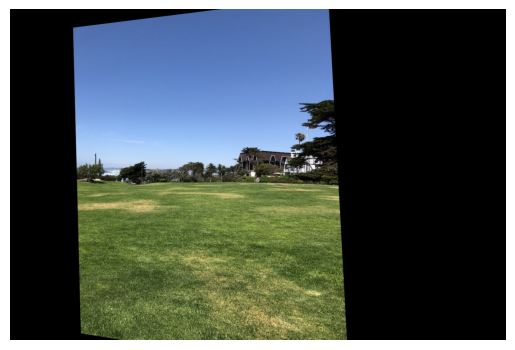

In [17]:
plt.imshow(cv2.cvtColor(pano, cv2.COLOR_BGR2RGB))
plt.axis('off')

### Stitch image3 to warpedImg4

In [18]:
# stitch the images together
pano[:h, :w] = image3

(np.float64(-0.5), np.float64(1511.5), np.float64(1007.5), np.float64(-0.5))

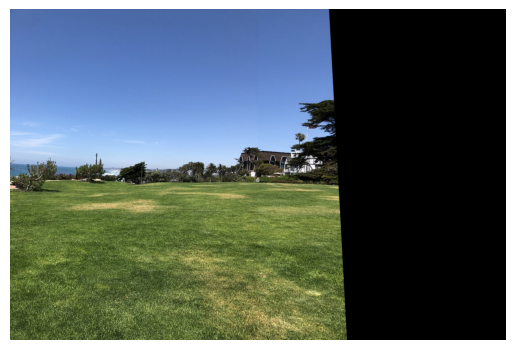

In [19]:
plt.imshow(cv2.cvtColor(pano, cv2.COLOR_BGR2RGB))
plt.axis('off')

## Image 34 -> Image 2

### Warp stitchedImg34 to image 2

In [20]:
# Calculate the size of the output image
h, w = image2.shape[:2]
pano_width = w + pano.shape[1]
pano_height = h

print(h,w)
print(pano_width, pano_height)

1008 756
2268 1008


(np.float64(-0.5), np.float64(2267.5), np.float64(1007.5), np.float64(-0.5))

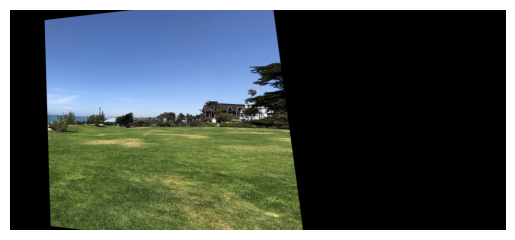

In [21]:
pano234 = cv2.warpPerspective(pano, M23, (pano_width, pano_height))
plt.imshow(cv2.cvtColor(pano234, cv2.COLOR_BGR2RGB))
plt.axis('off')

### Stitch image2 and stitchedImg34

(np.float64(-0.5), np.float64(2267.5), np.float64(1007.5), np.float64(-0.5))

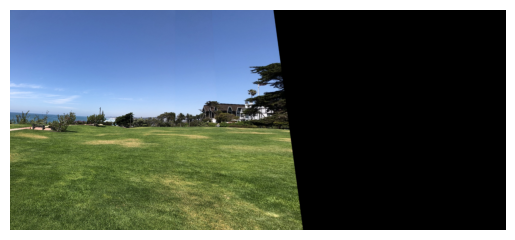

In [22]:
pano234[:h, :w] = image2
plt.imshow(cv2.cvtColor(pano234, cv2.COLOR_BGR2RGB))
plt.axis('off')

## Image 234 -> Image 1

### Warp stitchedImg234 to image 1

In [23]:
# Calculate the size of the output image
h, w = image1.shape[:2]
pano_width = w + pano234.shape[1]
pano_height = h

print(h,w)
print(pano_width, pano_height)

1008 756
3024 1008


(np.float64(-0.5), np.float64(3023.5), np.float64(1007.5), np.float64(-0.5))

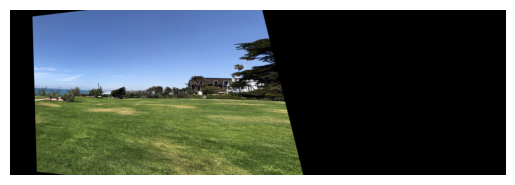

In [24]:
pano1234 = cv2.warpPerspective(pano234, M12, (pano_width, pano_height))
plt.imshow(cv2.cvtColor(pano1234, cv2.COLOR_BGR2RGB))
plt.axis('off')

### Stitch image1 with stitchedImg234

(np.float64(-0.5), np.float64(3023.5), np.float64(1007.5), np.float64(-0.5))

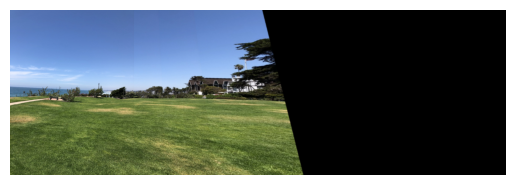

In [25]:
pano1234[:h, :w] = image1
plt.imshow(cv2.cvtColor(pano1234, cv2.COLOR_BGR2RGB))
plt.axis('off')

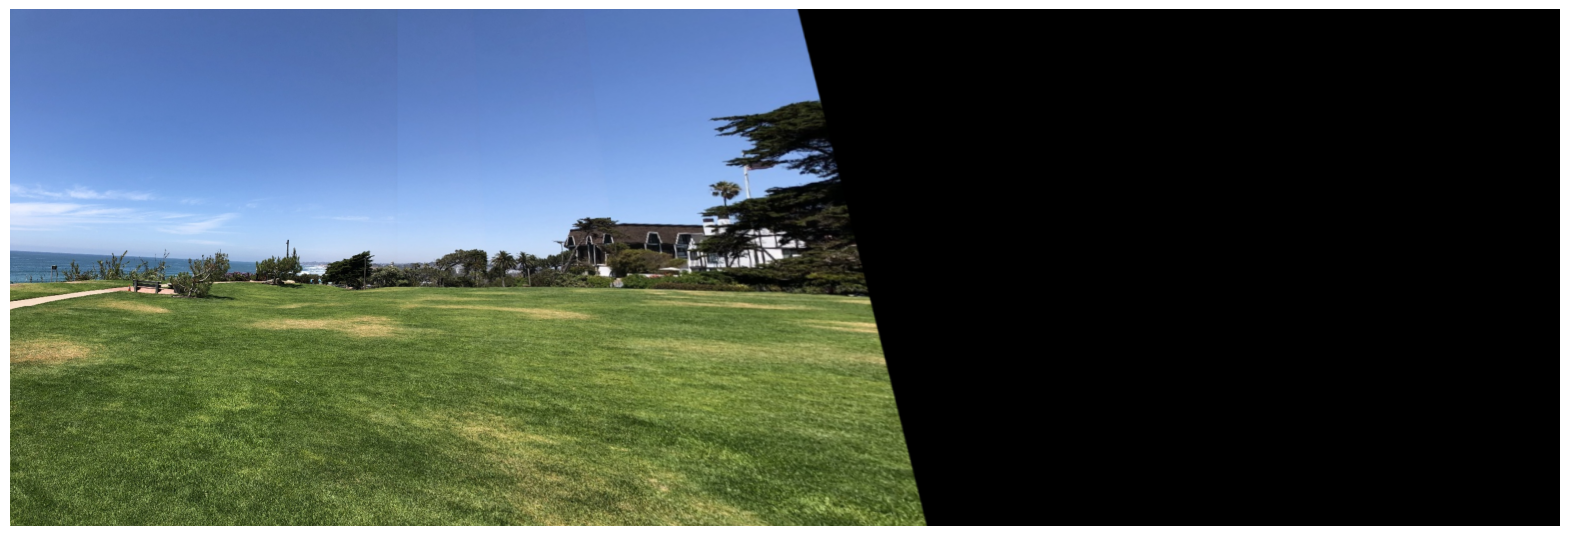

In [26]:
# cv2_imshow(pano1234)

# Use maplotlib to display the final panorama
plt.figure(figsize=[20,10])
plt.axis('off')
plt.imshow(cv2.cvtColor(pano1234, cv2.COLOR_BGR2RGB))
plt.show()

# Stitch images using OpenCV Stitch class

In [27]:
# Read Images

imagefiles = glob.glob('./panorama/*')
print(imagefiles)
imagefiles.sort()

images = []
for filename in imagefiles:
  img = cv2.imread(filename)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  images.append(img)

num_images = len(images)
print(num_images)

['./panorama\\scene1.jpg', './panorama\\scene2.jpg', './panorama\\scene3.jpg', './panorama\\scene4.jpg', './panorama\\scene5.jpg', './panorama\\scene6.jpg', './panorama\\scene7.jpg', './panorama\\scene8.jpg']
8


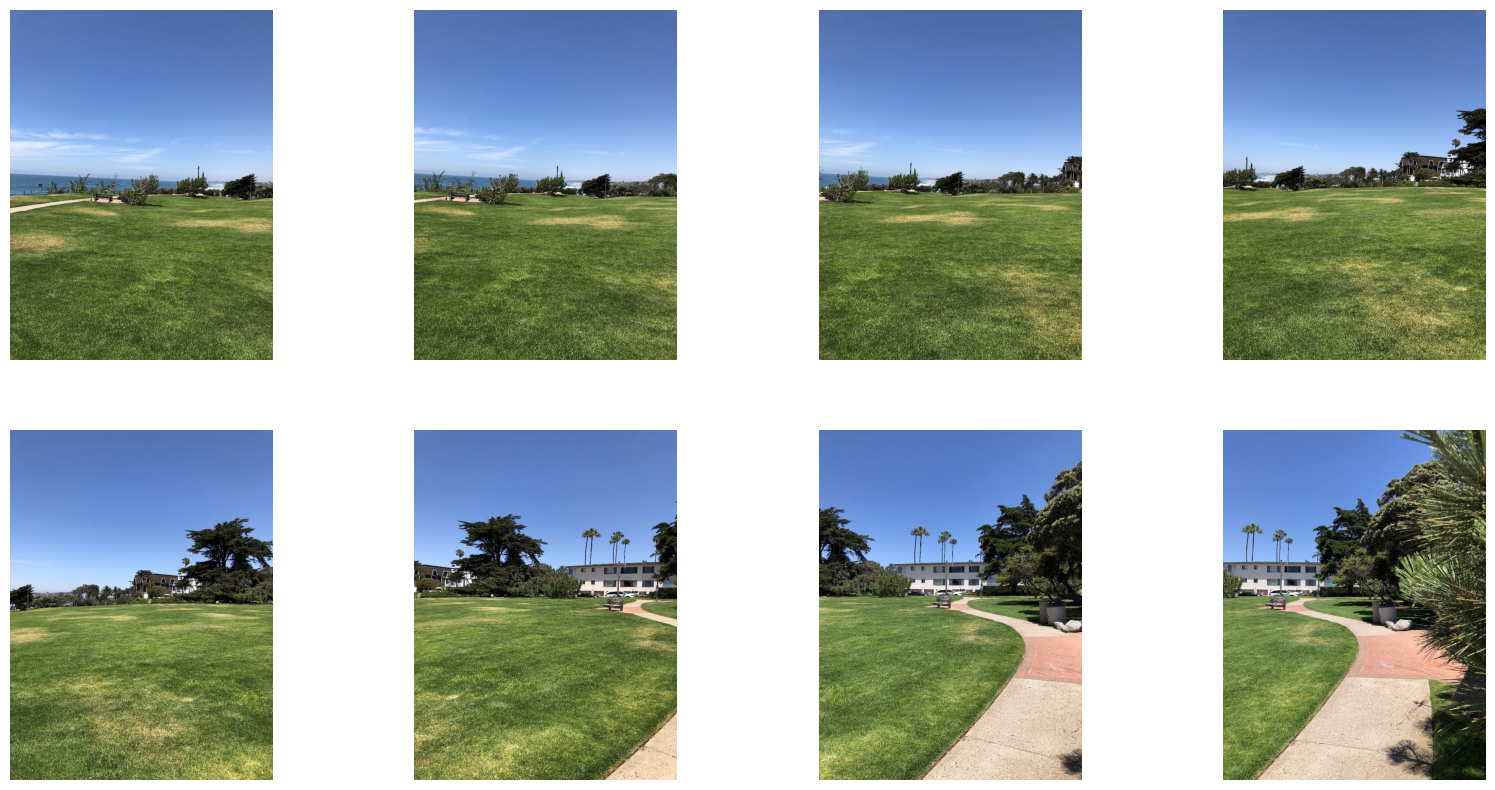

In [28]:
# Display Images
plt.figure(figsize=[20,10])
num_cols = 4
num_rows = math.ceil(num_images / num_cols)
for i in range(0, num_images):
  plt.subplot(num_rows, num_cols, i+1)
  plt.axis('off')
  plt.imshow(images[i])

## Stitch images

0


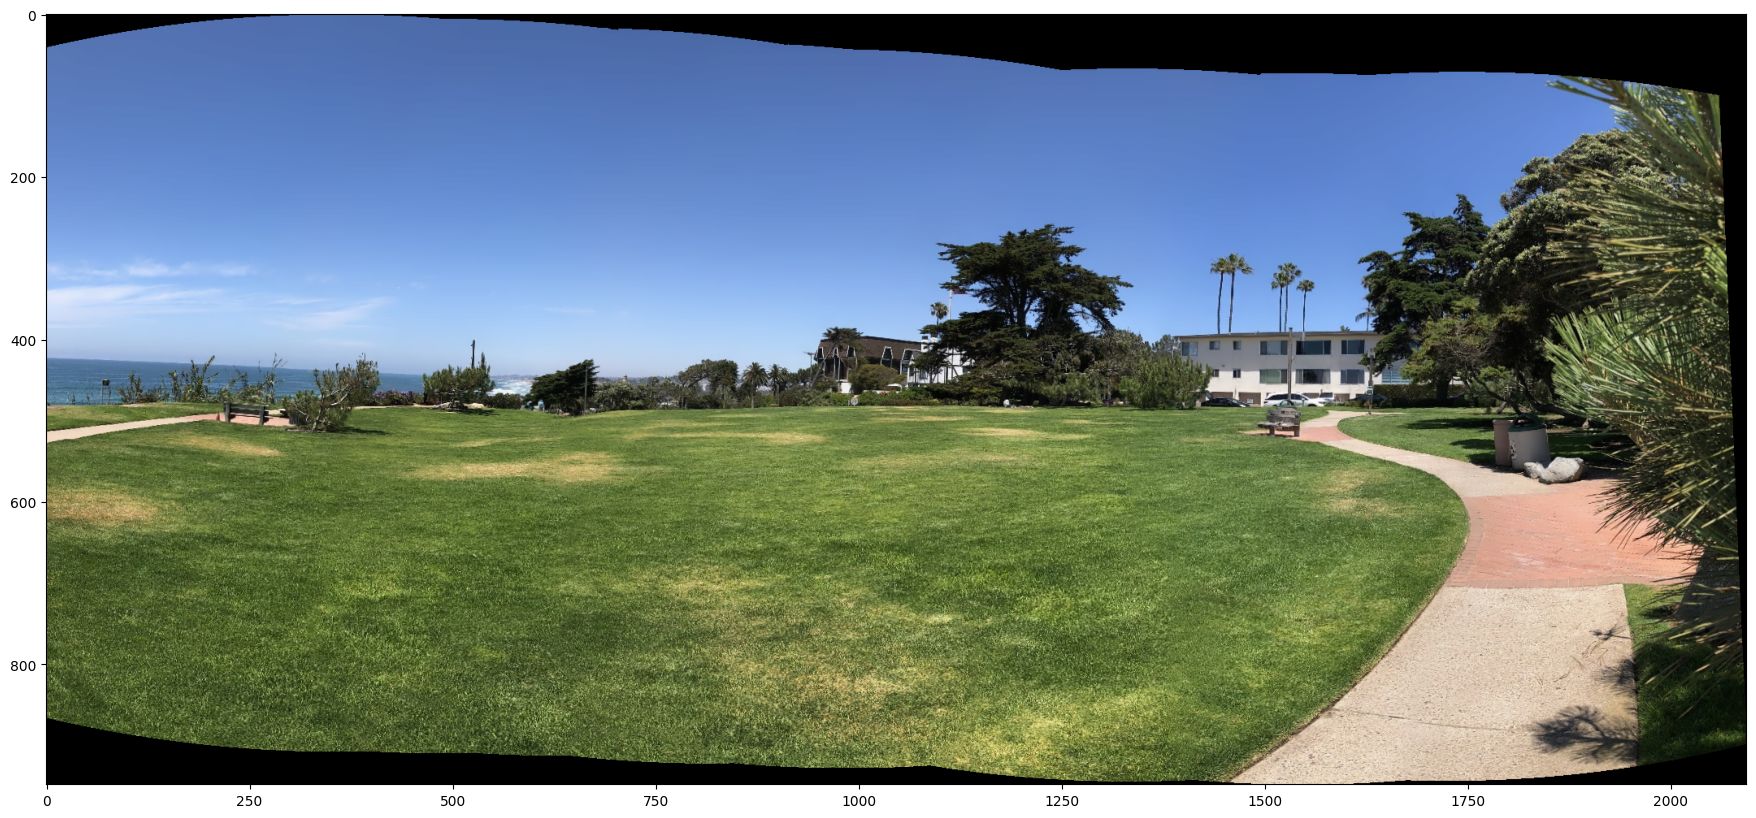

In [29]:
# Stitch Images
stitcher = cv2.Stitcher_create()
status, result = stitcher.stitch(images)
print(status)
if status == 0:
  plt.figure(figsize=[30,10])
  plt.imshow(result)